In [100]:
import re
import random
import pandas as pd
import hashlib

In [101]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [102]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Logging in Python,186.231493,37.246299,63.000383,5
Pandas,324.780271,36.086697,51.784272,9
CCH Axcess,468.120745,16.142095,30.948278,29
DAX,549.042761,61.004751,142.930606,9
Azure Private DNS,799.621611,88.846846,190.989555,9
Terraform,1054.311122,87.859260,267.927023,12
Azure AD Authentication,1195.977797,99.664816,157.439933,12
Azure Functions + PP365,1408.385182,88.024074,245.022146,16
Microsoft Purview,1462.813488,30.475281,47.439373,48
TSQL,1563.483583,65.145149,168.767292,24


# Histogram

sum of ages: ~52223.88


<Axes: >

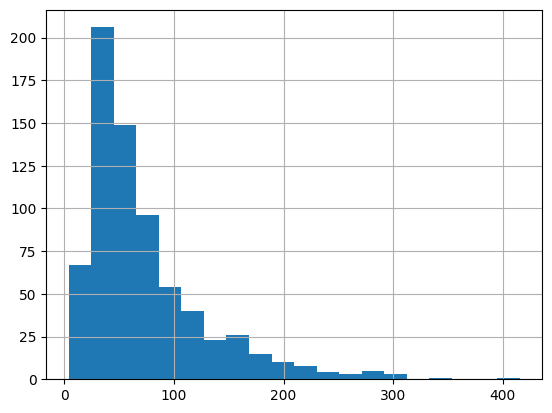

In [103]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52223.88


<Axes: >

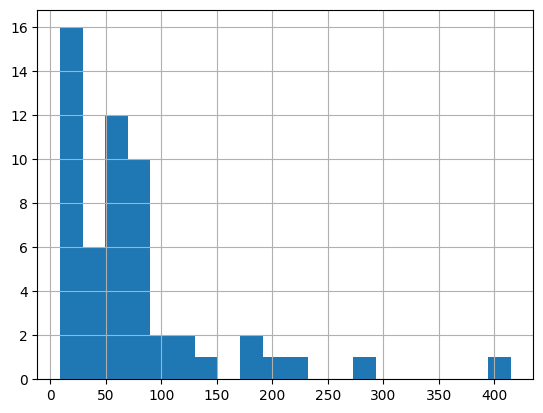

In [104]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [105]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [106]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [107]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [108]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [109]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [110]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [111]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [112]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [113]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [114]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 711
Total card age: 52223.88


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
192,Azure Developer Associate,A company has an App Service web app that requ...,786eb611c1ad4b131a5b90871a4e2fd8,415.187622,73.638192,-415.187622,4050.100548,0.289122,55,0,0,-415.187622
195,Azure Developer Associate,You manage an instance of Azure API Management...,c0b82fc28cca28291374fe4dd5aa53b2,204.355014,73.638192,-415.187622,4050.100548,0.289122,55,3,0,-204.355014
198,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,23f8c097cdb19c59487eaf4f3f725fce,131.358700,73.638192,-415.187622,4050.100548,0.289122,55,6,0,-131.358700
201,Azure Developer Associate,For the .NET SDK for Azure Cosmos DB for NoSQL...,e2ff6f3c584a2c6c5faf78dcae2eb263,104.483405,73.638192,-415.187622,4050.100548,0.289122,55,9,0,-104.483405
360,Azure Developer Associate,"In Read and Delete mode, Service Bus receives ...",0d0d551c38b7482b5aca8d90bb7ff41e,79.656553,73.638192,-415.187622,4050.100548,0.289122,55,12,0,-79.656553
363,Azure Developer Associate,"In Azure App Configuration,\nFeature manager: ...",c901a14baf95edb2e2619bb15f279978,74.000093,73.638192,-415.187622,4050.100548,0.289122,55,15,0,-74.000093
498,Azure Developer Associate,Azure Service Bus is a fully managed enterpris...,14990a4c3513cfbc002f19336ba4948b,71.815690,73.638192,-415.187622,4050.100548,0.289122,55,18,0,-71.815690
502,Azure Developer Associate,This question tests the candidate's knowledge ...,6f128343401ab9e2a4268777ff6aef05,68.770248,73.638192,-415.187622,4050.100548,0.289122,55,21,0,-68.770248
501,Azure Developer Associate,This item tests the candidate’s knowledge of c...,4d24dc4ff07af1235d8d138d70d5c251,64.185269,73.638192,-415.187622,4050.100548,0.289122,55,24,0,-64.185269
506,Azure Developer Associate,"In the Azure Service Bus Peek Lock mode, the r...",7cab65cc344de0256430a9d4d2ce94af,57.750670,73.638192,-415.187622,4050.100548,0.289122,55,27,0,-57.750670


## Card Count

In [115]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [116]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [117]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
192,Azure Developer Associate,A company has an App Service web app that requ...,786eb611c1ad4b131a5b90871a4e2fd8,415.187622,73.638192,-415.187622,4050.100548,0.289122,55,0,0,-415.187622
102,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,344.393270,92.624654,-344.393270,2778.739633,0.684438,30,0,0,-344.393270
112,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,308.166019,91.721463,-308.166019,2843.365368,0.845804,31,0,0,-308.166019
152,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,295.143973,92.404375,-295.143973,3511.366243,0.610113,38,0,0,-295.143973
62,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,291.988884,103.823298,-291.988884,1661.172767,0.414038,16,0,0,-291.988884
63,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,288.431374,103.823298,-291.988884,1661.172767,0.414038,16,1,1,-288.431374
193,Azure Developer Associate,The top-level resource in Azure Container Inst...,3f04022b2316ce5e2c67d6b869e6aea9,286.305030,73.638192,-415.187622,4050.100548,0.289122,55,1,1,-286.305030
153,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,286.293070,92.404375,-295.143973,3511.366243,0.610113,38,1,1,-286.293070
182,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,283.247727,60.132428,-283.247727,3187.018689,0.492136,53,0,0,-283.247727
82,PowerShell Modules,Find-Module\n\nDefinition: Searches for module...,4441d462ea754e1bb6a659efa359382f,279.936324,94.848798,-279.936324,2560.917547,0.128740,27,0,0,-279.936324


In [118]:
existing_cards['age'].mean()

73.45131130796213